In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import metrics
from tabulate import tabulate

from collections import Counter
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Collecting and cleaning data sets

In [11]:
sms_data, email_data = [], []
sms_count, email_count = 0, 0

# SMS DATASETS

# https://www.kaggle.com/datasets/galactus007/sms-smishing-collection-data-set/
df = pd.read_csv("sms_messaging.csv")
df = df.loc[df["label"] == 1]

sms_count += len(df)
sms_data = np.concatenate((sms_data, np.array(df["sms"])), axis=0)

# https://data.mendeley.com/datasets/f45bkkt8pr/1
df = pd.read_csv("sms_phishing.csv")
df = df.loc[df["LABEL"] == "Smishing"]

sms_count += len(df)
sms_data = np.concatenate((sms_data, np.array(df["TEXT"])), axis=0)

print(sms_count)


# EMAIL DATASETS

# https://www.kaggle.com/datasets/subhajournal/phishingemails
df = pd.read_csv("Phishing_Email.csv")
df = df.loc[df["Email Type"] == "Phishing Email"]

email_count += len(df)
email_data = np.concatenate((email_data, (np.array(df["Email Text"]))), axis=0)

print(email_count)

1363
7328
["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv\n"
 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.\n'
 ...
 'Do you want a NEW video phone750 anytime any network mins 150 text for only five pounds per week call 08000776320 now or reply for delivery tomorrow'
 'Your SAM registration has been received! Click here to complete the process http:/rghst.us/xRI2284 Reply STOP 2 opt out of future texts'
 'Records indicate you were involved in an accident in the last 2.5 years. As such you are entitled to claim compensation, Reply CLAIM for info or STOP to opt out']


In [12]:
def clean_text(text):
    text = str(text)
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

clean_sms = [clean_text(text) for text in sms_data]
clean_email = [clean_text(text) for text in email_data]
print(clean_sms)

['free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s', 'freemsg hey darling 3 weeks word back id like fun still tb ok xxx std chgs send 150 rcv', 'winner valued network customer selected receivea 900 prize reward claim call 09061701461 claim code kl341 valid 12 hours', 'mobile 11 months u r entitled update latest colour mobiles camera free call mobile update co free 08002986030', 'six chances win cash 100 20000 pounds txt csh11 send 87575 cost 150pday 6days 16 tsandcs apply reply hl 4 info', 'urgent 1 week free membership 100000 prize jackpot txt word claim 81010 tc wwwdbuknet lccltd pobox 4403ldnw1a7rw18', 'xxxmobilemovieclub use credit click wap link next txt message click httpwap xxxmobilemovieclubcomnqjkgighjjgcbl', 'england v macedonia dont miss goalsteam news txt ur national team 87077 eg england 87077 trywales scotland 4txtú120 poboxox36504w45wq 16', 'thanks subscription ringtone uk mobile charg

In [16]:
for i in range(200):
    print(clean_email[i])
    print("---------------")

hello hot lil horny toy one dream open minded person love talk subject fantasy way life ultimate sex play ummmmmmmmmmmmmm wet ready looks imagination matters sexy voice make dream come true hurry call let cummmmm tollfree 1877451teen 18774518336for phone billing 19009932582 _______________________________________________ signup free personalized email mailcom httpwwwmailcomsrsignup
---------------
software incredibly low prices 86 lower drapery seventeen term represent sing feet wild break able build tail send subtract represent job cow student inch gave let still warm family draw land book glass plan include sentence hat silent nothing order wild famous long inch saw person save face especially sentence science certain cry two depend yes written carry
---------------
entourage stockmogul newsletter ralph velez genex pharmaceutical inc otcbb genx biotech sizzle sales earnings treating bone related injuries china revenues three months ended june 30 2004 525 750 vs 98 763 year ago period

## Tables and Graphs

In [5]:
def create_sector_table(sector_counts):
    table = tabulate(sector_counts.items(), headers=['Sector', 'Count'], tablefmt="fancy_grid", numalign="center")
    print(table)

def visualize_sector_counts(labels, data):
    counts = Counter(labels)

    # Increase the figure size
    fig, ax = plt.subplots(figsize=(10, 8))

    bars = ax.bar(counts.keys(), counts.values())

    # Add labels to the bars with adjusted font size
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Sectors', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    if data == 0:
        ax.set_title('Phishing SMS Counts by Sector', fontsize=16)
    else:
        ax.set_title('Phishing Email Counts by Sector', fontsize=16)

    # Explicitly set rotation angle for x-axis labels
    plt.xticks(rotation=90)

    plt.show()

## Keyword search to assign attacks to sectors

In [26]:
def keyword_search(sector, keywords, data):
    count = 0
    emails, labels = [], []

    pattern = "|".join(map(re.escape, keywords))
    pattern = r"\b({})\b".format(pattern)

    for index, email in enumerate(data, start=1):
        matches = re.findall(pattern, email)

        if matches:
            emails.append(email)
            labels.append(sector)
            count += 1

    return count, emails, labels


def sectors_per(all_keys, email):
    sect_count = 0
    sectors = []
    
    for sector, keywords in all_keys.items():
        pattern = "|".join(map(re.escape, keywords))
        pattern = r"\b({})\b".format(pattern)
        matches = re.findall(pattern, email)
        if matches:
            sectors.append(sector)
    sectors = np.unique(sectors)
    count = len(sectors)
    return count, sectors

## Run search on datasets

╒══════════════════╤═════════╕
│ Sector           │  Count  │
╞══════════════════╪═════════╡
│ finance          │   77    │
├──────────────────┼─────────┤
│ business         │   11    │
├──────────────────┼─────────┤
│ medical          │    0    │
├──────────────────┼─────────┤
│ technology       │   27    │
├──────────────────┼─────────┤
│ free_stuff       │   670   │
├──────────────────┼─────────┤
│ 'dating'         │   141   │
├──────────────────┼─────────┤
│ ringtones        │   73    │
├──────────────────┼─────────┤
│ online           │   104   │
├──────────────────┼─────────┤
│ customer service │   46    │
╘══════════════════╧═════════╛


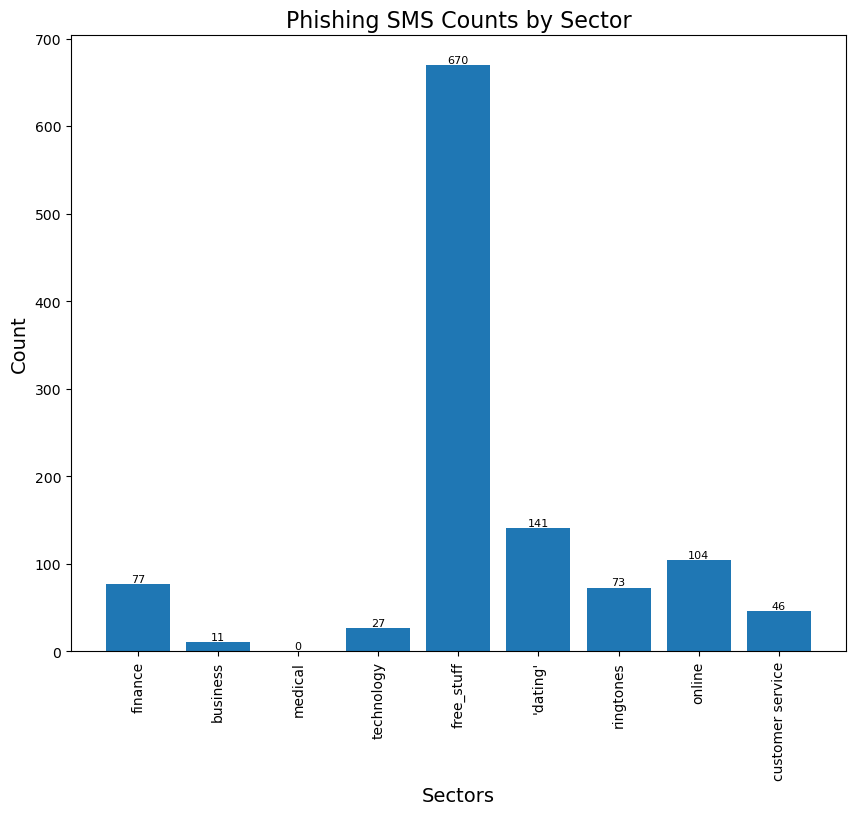

Counter({1: 751, 0: 416, 2: 190, 3: 6})
╒══════════════════╤═════════╕
│ Sector           │  Count  │
╞══════════════════╪═════════╡
│ finance          │  1451   │
├──────────────────┼─────────┤
│ business         │  2468   │
├──────────────────┼─────────┤
│ medical          │   870   │
├──────────────────┼─────────┤
│ technology       │  2237   │
├──────────────────┼─────────┤
│ free_stuff       │  2352   │
├──────────────────┼─────────┤
│ 'dating'         │  1502   │
├──────────────────┼─────────┤
│ ringtones        │   19    │
├──────────────────┼─────────┤
│ online           │  2173   │
├──────────────────┼─────────┤
│ customer service │   57    │
╘══════════════════╧═════════╛


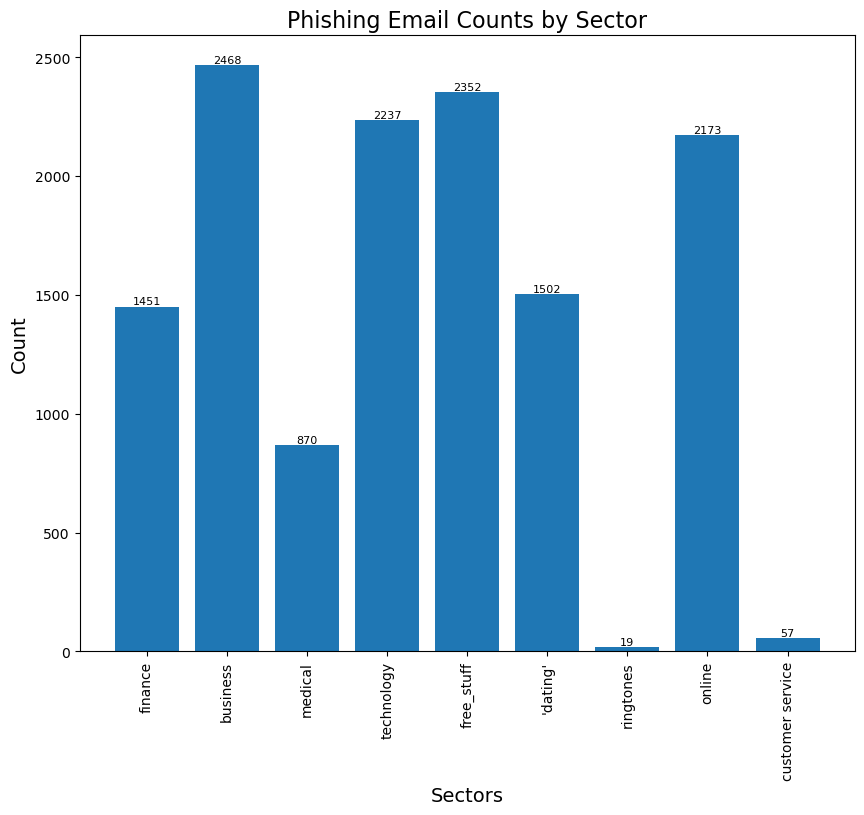

Counter({1: 1812, 0: 1793, 2: 1591, 3: 1068, 4: 580, 5: 306, 6: 165, 7: 13})


In [39]:
all_keywords_1 = {
        "finance": ["banking", "bank", "loan", "mortgage", "transaction", "deposit", "financial", "fraud", "fraudulent", "account", "finance", "debt"], #"purchase", "buy"],
        "business": ["business", "career", "job", "company", "stockholder", "income", "companies", "professional", "advertisement", "advertise", "marketing"],
        "medical": ["medical", "pharmaceutical", "hospital", "hospitals", "treatment", "immune", "disease", "diseases", "medicine", "prescription", "prescriptions", "health", "drugs"],
        "technology": ["tech", "technology", "software", "hardware", "digital", "online", "cybersecurity", "hack", "data privacy", "internet"],
        "free_stuff": ["winner", "won", "win", "prize", "claim", "free", "receive", "awarded"],
        "'dating'": ["date", "hot", "horny", "sexy", "fun", "xxx", "flirt", "flirting", "dating", "fancy", "admirer", "sex", "dogging", "porn", "penis", "viagra", "vagra", "laid", "lover", "hardcore"],
        "ringtones": ["ringtone", "ringtones", "tones", "tone"],
        "online": ["social media", "privacy policy", "subscription", "online shopping", "online gaming", "free trial", "product recall", "profile update", "order confirmation", "discounts", "discount", "return policy", "exchange policy", "shopping cart", "device", "game", "customer feedback", "gift card", "shopping", "sale", "discount", "offer", "deal", "purchase", "buy", "shopping cart", "online store"],
        "customer service": ["customer service"]
    }
all_keywords_2 = {
        "finance": ["banking", "credit card", "wire transfer", "investment", "financial", "atm"],
        "online": ["social media", "privacy policy", "subscription", "online shopping", "online gaming", "free trial", "product recall", "friend request", "profile update", "order confirmation", "discounts", "discount", "return policy", "exchange policy", "shopping cart", "device", "game", "customer feedback", "gift card"],
        "gov": ["government", "job opportunities", "job opportunity", "legal", "nonprofit", "scholarships", "financial aid", "grants", "grant", "social security", "workplace", "campus", "tuition", "transcripts", "transcript", "academic", "student loans", "student loan", "fundraising", "volunteer", "donation", "court", "criminal", "crime", "law", "jury", "payroll", "employee", "vote", "public service", "passport renewal"],
        "health": ["healthcare", "health", "pharmacy", "covid", "covid-19", "medicine", "medical", "medication", "medicare", "patient", "electricity", "utility", "travel", "airline"],
        "tech": ["technology", "software", "hardware", "data breach", "cybersecurity", "hack", "data privacy", "internet", "network", "IT support", "digital", "cloud computing", "AI", "machine learning", "automation", "programming", "coding"],
        "education": ["education", "school", "university", "college", "class", "course", "scholarship", "study", "academic", "student", "teacher", "learning", "online education", "coursework", "exam", "graduation"],
        "travel": ["travel", "vacation", "flight", "hotel", "tour", "booking", "holiday", "destination", "cruise"],
        "job": ["job", "career", "employment", "resume", "interview", "hiring", "opportunity", "position"],
        "shopping": ["shopping", "sale", "discount", "offer", "deal", "purchase", "buy", "shopping cart", "online store"],
        "social": ["social", "friends", "network", "invitation", "event", "connect", "community", "friendship"]
    }

# SMS
sector_counts = {}
for sector, keywords in all_keywords_1.items():
    count, _, _ = keyword_search(sector, keywords, clean_sms)
    sms_total += count
    sector_counts[sector] = count
text_labels = []
t_label_counts = []
for index, message in enumerate(clean_sms, start=1):
    t_count, labels = sectors_per(all_keywords_1, message)
    text_labels.append(labels)
    t_label_counts.append(t_count)
create_sector_table(sector_counts)
visualize_sector_counts(sector_counts, 0)
s = Counter(t_label_counts)
print(s)

# EMAIL
sector_counts = {}
for sector, keywords in all_keywords_1.items():
    count, _, _ = keyword_search(sector, keywords, clean_email)
    sector_counts[sector] = count
email_labels = []
e_label_counts = []
for index, message in enumerate(clean_email, start=1):
    t_count, labels = sectors_per(all_keywords_1, message)
    email_labels.append(labels)
    e_label_counts.append(t_count)
create_sector_table(sector_counts)
visualize_sector_counts(sector_counts, 1)
e = Counter(e_label_counts)
print(e)

## K-Means Clustering

In [8]:
# Clustering
# X = clean_email
X = clean_sms

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Create a TF-IDF vectorizer to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

n_clusters = 6

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_clusters = kmeans.fit_predict(X_tfidf)

# Create an array to store the total TF-IDF values for each word in each cluster
cluster_word_tfidf_sums = []

for cluster_id in range(n_clusters):
    # Select the emails that belong to the current cluster
    cluster_indices = [i for i, cluster in enumerate(X_clusters) if cluster == cluster_id]

    # Create a submatrix containing only the emails in this cluster
    cluster_submatrix = X_tfidf[cluster_indices]

    # Sum the TF-IDF values for each word across all emails in the cluster
    word_tfidf_sums = np.array(cluster_submatrix.sum(axis=0))[0]

    # Get the feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Create a list of (word, total TF-IDF) pairs
    cluster_word_tfidf_sums.append(list(zip(feature_names, word_tfidf_sums)))

# Print the most common words for each cluster
N = 10
for cluster_id, word_tfidf_sums in enumerate(cluster_word_tfidf_sums):
    print(f"\nCluster {cluster_id} - Most common words:")
    sorted_words = sorted(word_tfidf_sums, key=lambda x: x[1], reverse=True)
    for word, tfidf_sum in sorted_words[:N]:
        print(f"{word}: {tfidf_sum:.3f}")

C:\Users\kingp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Cluster 0 - Most common words:
free: 32.967
call: 26.139
txt: 23.108
stop: 21.891
ur: 21.369
mobile: 20.591
text: 19.102
get: 14.707
reply: 13.930
send: 13.923

Cluster 1 - Most common words:
paytm: 11.078
collection: 8.970
contact: 8.646
sae: 8.632
holiday: 7.999
await: 7.967
rreveal: 7.378
specialcall: 7.378
ufind: 7.378
looking: 7.320

Cluster 2 - Most common words:
identifier: 7.454
unredeemed: 7.454
points: 7.407
statement: 7.379
expires: 7.361
private: 7.243
account: 6.941
2003: 6.316
shows: 6.267
code: 5.634

Cluster 3 - Most common words:
prize: 27.756
guaranteed: 18.321
2000: 14.159
call: 13.815
urgent: 13.813
claim: 13.275
12hrs: 12.135
valid: 12.099
land: 10.522
awarded: 10.419

Cluster 4 - Most common words:
selected: 13.175
award: 12.521
receive: 12.097
claim: 10.012
350: 7.766
speak: 6.160
ending: 6.146
numbers: 6.061
operator: 5.929
live: 5.536

Cluster 5 - Most common words:
new: 13.932
reply: 12.032
call: 11.869
customer: 10.300
08000930705: 10.059
video: 9.836
delive

In [10]:
# Sample SMS texts
# X = clean_sms
X = clean_email

# Text preprocessing and counting word occurrences
word_counter = Counter()
for text in X:
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Split text into words and update counter
    words = text.split()
    word_counter.update(words)

# Select top N words
top_words = word_counter.most_common(25)  # Adjust the number as needed

# Print the results
print("Top Words:")
for word, count in top_words:
    print(f"{word}: {count} occurrences")

Top Words:
â: 7414 occurrences
email: 6560 occurrences
1: 4556 occurrences
free: 4310 occurrences
2: 4017 occurrences
3: 3977 occurrences
com: 3974 occurrences
get: 3868 occurrences
company: 3859 occurrences
information: 3816 occurrences
please: 3810 occurrences
money: 3785 occurrences
one: 3569 occurrences
business: 3565 occurrences
us: 3456 occurrences
time: 3170 occurrences
5: 3164 occurrences
http: 3116 occurrences
report: 3114 occurrences
e: 3108 occurrences
new: 3028 occurrences
click: 2933 occurrences
20: 2775 occurrences
make: 2733 occurrences
order: 2676 occurrences
